# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 3
&copy; 2021 Prof. Dr. Philipp Hennig & Nico Krämer & Emilia Magnani

This sheet is **due on Monday, November 15, 2021 at 10am sharp (i.e. before the start of the lecture).**

---

## Data estimation
In this week we will look at maximum likelihood estimation for exit polls / election data.
We will work with the results from the German general election in September 2021.
The full data set can be downloaded from the "Bundeswahlleiter":
https://www.bundeswahlleiter.de/bundestagswahlen/2021/ergebnisse/opendata/csv/
(explained in https://www.bundeswahlleiter.de/bundestagswahlen/2021/ergebnisse/opendata.html#39734920-0eaf-4633-8858-ae792d5d610b).

For this task, we will only require a subset of this data, which has already been slimmed down by us (you're welcome) and provided as a csv file (see 'data_slim.csv').


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.special

import matplotlib.tri as tri


# For the docstrings / type hints
from typing import Union, Optional, Tuple

rng = np.random.default_rng(seed=1)

**Task:** Load  the data 'data_slim.csv'.

In [2]:
data = pd.read_csv(r'data_slim.csv')

In [3]:
data.head()

,Unnamed: 0,Gruppenname,Anzahl,Prozent
0,7,CDU,8775471.0,18.0
1,9,SPD,11955434.0,25.0
2,11,AfD,4803902.0,10.0
3,13,FDP,5319952.0,11.0
4,15,DIE LINKE,2270906.0,4.0


To better understand the concepts, we will start with considering a two-party setup (where we assume there are only two parties), and then extend the concepts to multiple parties.


**Task:**
Pick a party (please pick one of the larger ones, otherwise the results are meaningless), and aggregate the number of votes into "Party X" and "Not party X".    
Then, create a list of all votes. For example, if  you choose "Party X" = "SPD", and "SPD" has 3 votes, and all the others ("Not party X") have 4 votes, create the list
["SPD", "SPD","SPD", "others", "others", "others", "others"]. This will be useful for subsampling the exit poll below.



In [8]:
# Divide in two parties and create a list of votes
def create_vote_list(party_x, data):

    total_votes = data['Anzahl'].sum()
    votes_party_x = int(data[data['Gruppenname'] == party_x]['Anzahl'])
    votes_party_not_x = int(total_votes - votes_party_x)
    list_of_votes = ([party_x] * votes_party_x) + (['others'] * votes_party_not_x)

    return list_of_votes

party_x = 'GRÜNE'
list_of_votes = create_vote_list(party_x, data)
print(len(list_of_votes))

46442023


## Exit polls

One common way of predicting election results is to conduct what is known as an exit poll.
An exit poll is a collection ("poll") of voters taken when they exit the polling stations. Exit polls are used to gain an early indication about the result of the elections.

In the next task we will use the German election data to simulate an exit poll.

**Task:** 
Write a function that subsamples $N$ votes from the aggregated voting results (with only two parties). If you prefer not to use the list created above for subsampling, feel free to be creative.


In [9]:
import random
# Write here your simulated exit poll function
def calc_exit_poll(party_x, data, n):
    votes = create_vote_list(party_x, data)
    return random.sample(votes,n)

exit_poll = calc_exit_poll(party_x, data, 10)
print(exit_poll)

['others', 'others', 'others', 'GRÜNE', 'others', 'others', 'others', 'others', 'others', 'others']


Now, we will use the exit poll results to _infer_ the true election results.
The overarching question will be _how large does the exit poll have to be for the prediction to be significant_? 

To this end, compute the likelihood of observing a given exit poll $N = [N_p, N_{\backslash p}]$ under _a_ probability distribution $\pi = (\pi_p, \pi_{\backslash p})$ ("p" is your party).

The likelihood is
$$
p(N \mid \pi) = \prod_{i=1}^2 \pi_i^{N_i}.
$$
$$
\log p(N \mid \pi) = \sum_{i=1}^2 {N_i} \cdot \log (\pi_i)
$$


**Task:**
Turn the likelihood function above into a python function (consider using a *log*likelihood instead of a likelihood for numerical stability. Normalisation of log likelihoods can be done in a stable way with the log-sum-exp trick; e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html )

In [10]:
from scipy.special import logsumexp
# Likelihood function 

def calc_likelihood(exit_poll, party, p_party):

    total_polls = len(exit_poll)
    ep_party = exit_poll.count(party)
    ep_not_party = total_polls-ep_party

    log_ll = ep_party * np.log(p_party) + ep_not_party * np.log(1-p_party)  
    #norm = logsumexp ?

    return log_ll


In [11]:
n_samples = 10
party = 'GRÜNE'
exit_poll = calc_exit_poll(party, data, n_samples)
p_party = 0.2

ll = calc_likelihood(exit_poll, party, p_party)
ll

-6.390318596501769

**Task:**
Plot this likelihood function (as a function of $\pi$) for different values of $N$, and find the maximum likelihood estimator for $\pi$, for each choice of $N$. 

How large does $N$ have to be for the MLE to be close to the truth?

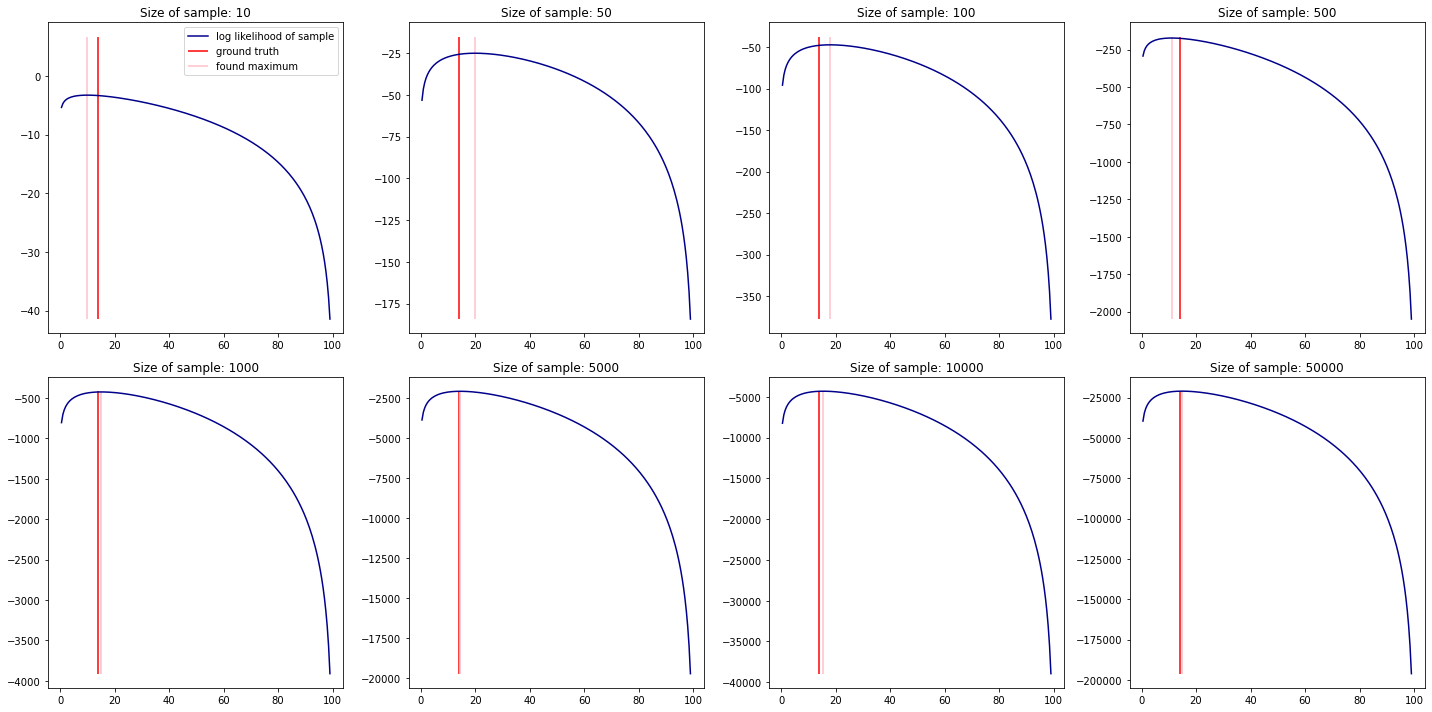

In [15]:
# Plot likelihood function for different values of N
N = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
party = 'GRÜNE'
gt = data[data['Gruppenname'] == party]['Prozent'].values

n_x_plots = 4
n_y_plots = 2
probs = np.arange(0.005, 0.995, 0.005)
x = probs * 100

fig, ax = plt.subplots(n_y_plots, n_x_plots, figsize=(20, 10))

for i in range(n_y_plots):
    for j in range(n_x_plots):
        current_N = N[int(i*n_x_plots+j)]
        exit_poll = calc_exit_poll(party, data, current_N)
        log_ll = calc_likelihood(exit_poll, party, probs)
        ax[i, j].plot(x, log_ll, color='darkblue', label='log likelihood of sample')
        ax[i, j].vlines(gt, np.min(log_ll), np.max(log_ll)+10, color='red', label='ground truth')
        idx_max = np.argmax(log_ll)
        ax[i, j].vlines(x[idx_max], np.min(log_ll), np.max(log_ll)+10, color='pink', label='found maximum')
        ax[i, j].set_title('Size of sample: ' + str(current_N))

ax[0,0].legend(loc='upper right')
plt.tight_layout();

A N of size 5000 seems to be sufficiently large.

## Predicting wins and losses


The exit poll subsampling strategy can be used to predict the probabilities of a party winning an election, or exceeding a certain threshold of vote shares.


**Task:** Plot the probability of the vote shares of DIE LINKE exceeding $\tau = 0.1$ as a function of the exit poll size $N$. Do the same for SPD and threshold $\tau=0.2$. What value of $N$ seems sufficient to predict the actual outcomes?


In [17]:
import scipy.stats
# now we need a binomial distribution in order to compute the probability of vote counts
def calc_binom_prob(exit_poll, party, threshold):

    N = len(exit_poll)
    # compute maximum number of votes that do not exceed the threshold
    max_votes = int(threshold*N)

    # choose p to be the percentage of votes in the exit poll
    p = exit_poll.count(party) / N

    # compute cumulative likelihood for the maximum vote count allowed
    cum_prob = scipy.stats.binom(n=N, p=p).cdf(max_votes)
    
    # return counter probability
    return 1 - cum_prob

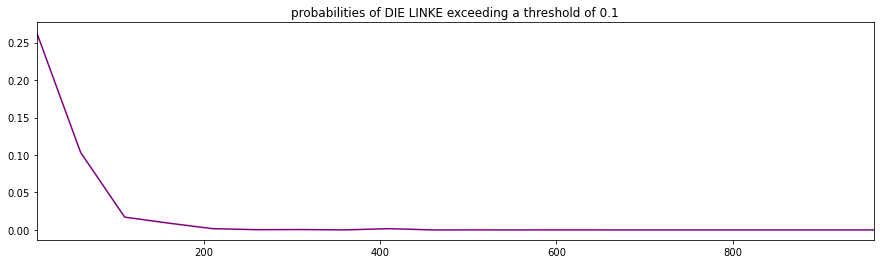

In [18]:
# Plot for DIE LINKE 
party = 'DIE LINKE'
threshold = 0.1
N = np.arange(10, 1000, 50)

probs = []
for n in N:
    exit_poll = calc_exit_poll(party, data, n)
    prob = calc_binom_prob(exit_poll, party, threshold)
    probs.append(prob)

plt.figure(figsize=(15, 4))
plt.plot(N, probs, color='purple')
plt.xlim(N[0], N[-1])
plt.title('probabilities of DIE LINKE exceeding a threshold of 0.1');

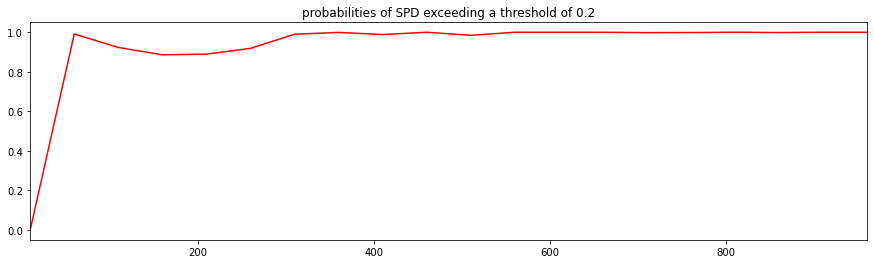

In [19]:
# Plot for SPD 
party = 'SPD'
threshold = 0.2
N = np.arange(10, 1000, 50)

probs = []
for n in N:
    exit_poll = calc_exit_poll(party, data, n)
    prob = calc_binom_prob(exit_poll, party, threshold)
    probs.append(prob)

plt.figure(figsize=(15, 4))
plt.plot(N, probs, color='red')
plt.xlim(N[0], N[-1])
plt.title('probabilities of SPD exceeding a threshold of 0.2');

In both cases the curve stabilizes after drawing about 600-800 samples.

# Multiple parties

Here we generalise the reasoning from above to more than two parties (actually, three). For plotting we will use a 3-simplex (see below).

**Task:** Pick two parties, and  split the dataset into Party 1, Party 2 and "others". You may use the `aggregate()` function below.

In [20]:
def aggregate(
    my_party1: str, my_party2: str, data: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Aggregate the counts of two parties in the election data set.
    
    Parameters
    ----------
    my_party1
        String describing a party.
    my_party2
        String describing a party.
    data
        Election data to be aggregated from.
    
    Returns
    -------
    votes_all
        Aggregated list of votes ["P1", ..., "P1", "P2", ..., "P2", "others", ..., "others"]
    parties_all
        List of strings, describing the two parties and "others"
    truth
        True distribution of votes (as percentages) in the aggregated list of election results.
    """
    result_my_party1 = int(data[data["Gruppenname"] == my_party1]["Anzahl"].sum())
    result_my_party2 = int(data[data["Gruppenname"] == my_party2]["Anzahl"].sum())
    result_others = int(
        data[
            np.logical_and(
                data["Gruppenname"] != my_party1, data["Gruppenname"] != my_party2
            )
        ]["Anzahl"].sum()
    )

    truth = np.array([result_my_party1, result_my_party2, result_others]) / (
        result_my_party1 + result_my_party2 + result_others
    )
    votes_all = np.concatenate(
        (
            np.tile(my_party2, result_my_party2),
            np.tile(my_party1, result_my_party1),
            np.tile("others", result_others),
        )
    )
    parties_all = np.array([my_party1, my_party2, "others"])
    return votes_all, parties_all, truth

my_party1, my_party2 = "GRÜNE", "SPD"
votes_all, parties_all, truth = aggregate(my_party1, my_party2, data)

The code below defines a triangulation, and provides functions which transform Cartesian to Barycentric ("Simplex") coordinates. You can use this code for the next task ( so there is nothing for you to change here).

In [21]:
# Define the triangle
corners = np.array([[0, 0], [1, 0], [0.5, 0.75 ** 0.5]])

# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 for i in range(3)]

triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=8)


def cartesian_to_barycentric(
    xy: np.ndarray,
    corners: np.ndarray,
    midpoints: np.ndarray,
    tol: Optional[float] = 1.0e-3,
) -> np.ndarray:
    """Converts Cartesian coordinates to Barycentric.
    
    Parameters
    ----------
    xy
        Cartesian coordinates. Array of shape (2,).
    corners
        Corners of the triangles. Array of shape (3,2).
    midpoints
        Midpoints of the triangles. Array of shape (3,2).
    tol
        A small value that describes when to clip values really close to 0 or 1.
    
    Returns
    -------
    Barycentric coordinate representation of the Cartesian coordinates. Array of shape (3,).
    """
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def barycentric_to_cartesian(bc: np.ndarray, corners: np.ndarray) -> np.ndarray:
    """Converts Barycentric coordinates to Cartesian coordinates.
    
    Parameters
    ----------
    bc
        Barycentric coordinates. Array of shape (3,).
    corners
        Corners of the triangles. Array of shape (3,2).
    
    Returns
    -------
    Cartesian coordinate representation of the Barycentric coordinates. Array of shape (2,).
    """
    return bc @ corners

As above, we will plot the likelihood function (as a function of $\pi$ ) for different values of $N$. In the simplex plot below, each coordinate represents a vote share distribution between party 1, party 2, and "others" (In fact here $\pi$ is a probability distribution $\pi = (\pi_\text{party1}, \pi_\text{party2}, \pi_\text{others})$). 

**Task:** 
Replace the placeholder contour lines below with the probability of observing the exit poll given the distribution implied by the coordinates. Also, compute the MLE and plot it next to the true distribution of vote shares/portions/... .


In [42]:
def calc_likelihood(exit_poll, parties_all, p_space):

    total_log_ll = 0

    for idx, party in enumerate(parties_all):
        ep_party = exit_poll.count(party)
        total_log_ll += ep_party * np.log(p_space[:, idx])

    return total_log_ll

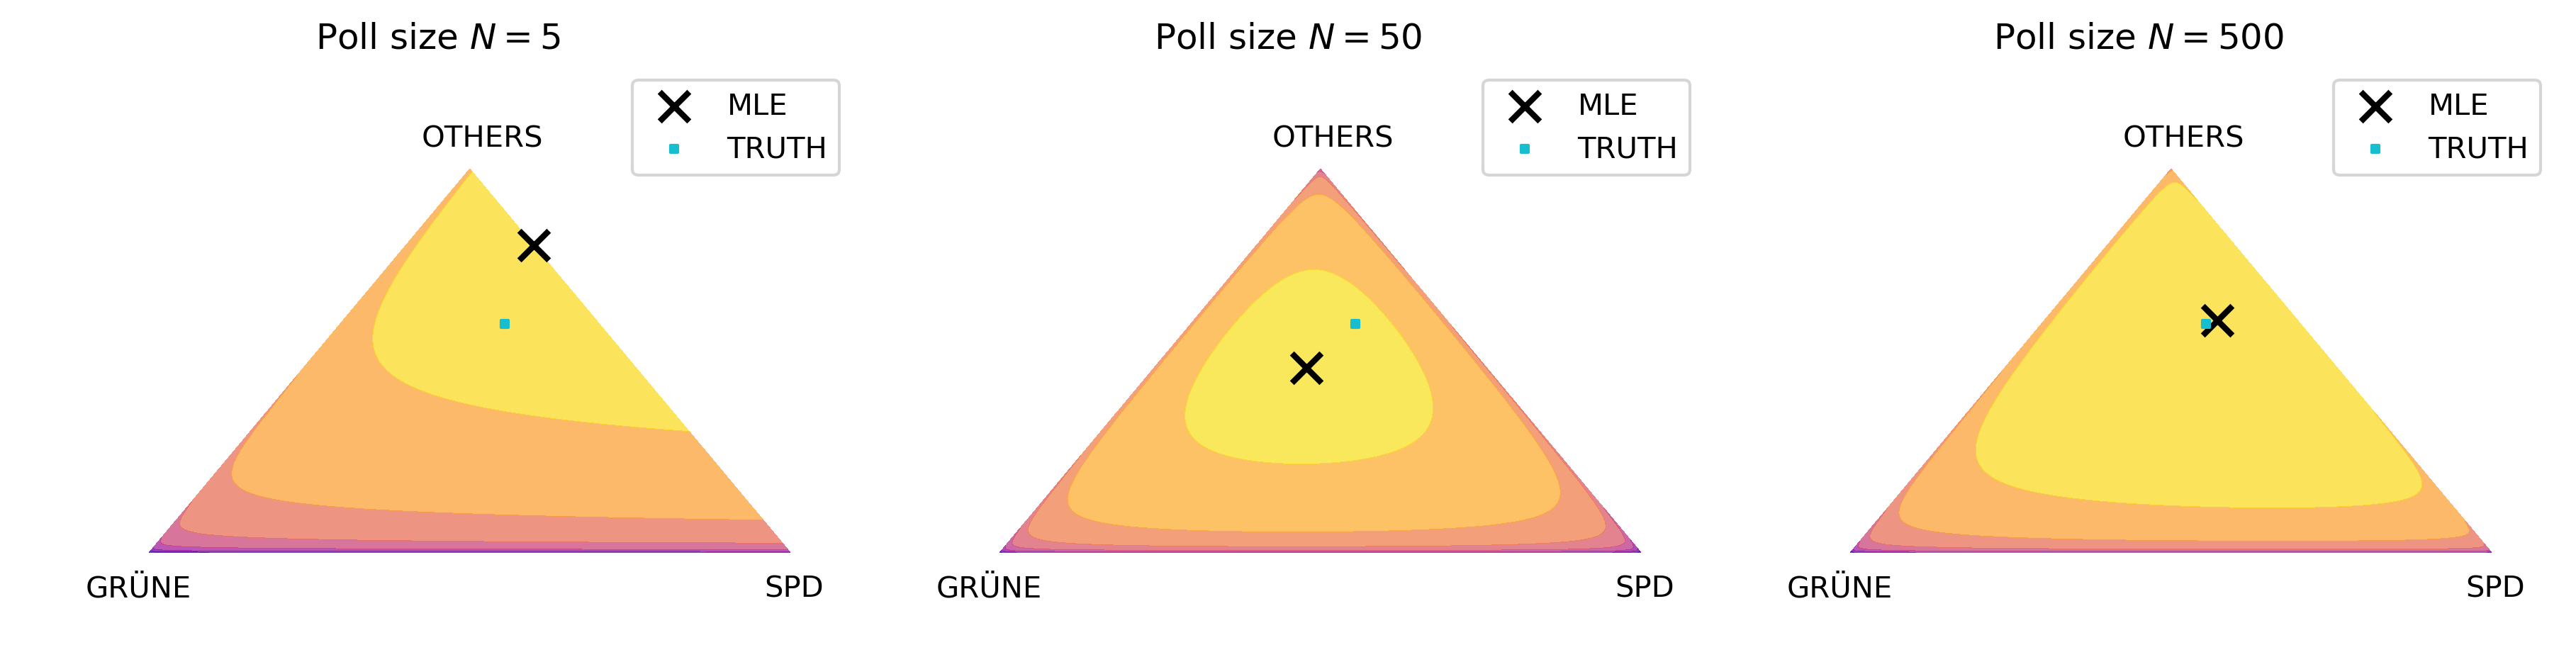

In [61]:
p_space = np.stack([cartesian_to_barycentric(p, corners=corners, midpoints=midpoints) for p in zip(trimesh.x, trimesh.y)])
fig, axes = plt.subplots(
    ncols=3, figsize=(12, 3), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

truth_in_simplex = barycentric_to_cartesian(truth, corners=corners)
for poll_size, axis in zip([5, 50, 500], axes):

    # Placeholder
    # Replace the uniform random numbers with likelihoods below
    exit_poll = random.sample(votes_all.tolist(), poll_size)
    total_log_ll = calc_likelihood(exit_poll, parties_all, p_space)
    axis.tricontourf(trimesh, total_log_ll, cmap="plasma", alpha=0.75)
    # Include the actual MLE and the actual truth here: the numbers below are placeholders
    mle_idx = np.argmax(total_log_ll)
    mle_p = p_space[mle_idx]
    mle_in_simplex = barycentric_to_cartesian(mle_p, corners=corners)
    axis.scatter(mle_in_simplex[0], mle_in_simplex[1], marker="x", s=100, color="k", linewidth=2, label="MLE")
    axis.scatter(truth_in_simplex[0], truth_in_simplex[1], marker=",", s=6, color="tab:cyan", label="TRUTH")

    
    axis.set_title(f"Poll size $N={poll_size}$")

    axis.annotate(my_party1, (-0.1, -0.1))
    axis.annotate(my_party2, (0.96, -0.1))
    axis.annotate("OTHERS", (0.5 - 0.075, 0.75 ** 0.5 + 0.05))

    axis.set_xlim((-0.2, 1.1))
    axis.set_ylim((-0.2, 1.1))

    axis.set_xticks(())
    axis.set_yticks(())
    axis.legend()

for axis in axes:
    axis.spines["right"].set_visible(False)
    axis.spines["top"].set_visible(False)
    axis.spines["bottom"].set_visible(False)
    axis.spines["left"].set_visible(False)

plt.show()

Based on these results, think about what size N you would use for your exit poll, if your goal was to identify the voting shares of all parties to, say, within the nearest percentage point. (You do not need to provide an answer in this sheet, this topic will be discussed in subsequent lectures).

### THEORY QUESTION

In [62]:
X = np.array([ 101,1,93, 78,239, 185,65,202,12, 125 ])

In [67]:
def ll(theta, X):
    if theta < np.max(X):
        return 0
    else:
        return (1/theta)**len(X)

In [111]:
thetas = np.arange(0, 600, 1)
lls = np.array([ll(theta, X) for theta in thetas])
norm_lls = lls / lls.sum()

In [154]:
perc25 = np.where(norm_lls.cumsum() <= 0.25)[0][-1]
perc50 = np.where(norm_lls.cumsum() <= 0.5)[0][-1]
perc75 = np.where(norm_lls.cumsum() <= 0.75)[0][-1]

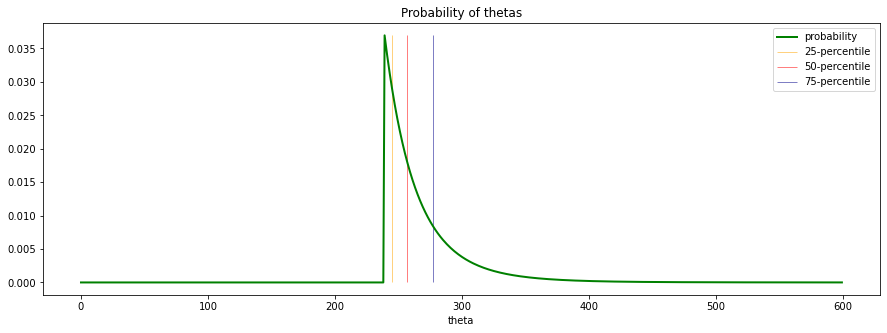

In [165]:
plt.figure(figsize=(15, 5))
plt.plot(norm_lls, color='green', linewidth=2, label='probability')
plt.title('Probability of thetas')
plt.vlines(perc25, 0, np.max(norm_lls), colors='orange', linewidth=0.5, label='25-percentile')
plt.vlines(perc50, 0, np.max(norm_lls), colors='red', linewidth=0.5, label='50-percentile')
plt.vlines(perc75, 0, np.max(norm_lls), colors='darkblue', linewidth=0.5, label='75-percentile')
plt.xlabel('theta')
plt.legend();